16-14. 프로젝트 : SRGAN 활용하기
앞에서 사용했던 SRGAN 구조를 이용해 프로젝트를 수행해 봅시다.


프로젝트 1-1.

(적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. cv2.resize()를 사용해 봅시다. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다. 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 cv2.resize()를 사용해 봅시다. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다) 

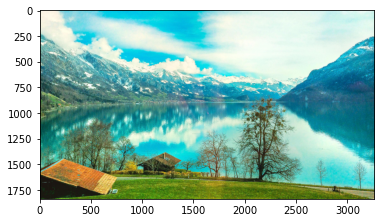

In [9]:
from IPython import display 
import numpy as np
import urllib
import PIL
%matplotlib inline
from matplotlib.pyplot import imshow

# jupyter notebook에 이미지를 표시하는 아래의 방법이 있지만 여기서는 imshow를 통해서 출력했다.
# display.Image보다 imshow를 쓰는것이 해상도를 파악하기 쉽기 때문(좌표계가 나와서...)
# display.Image("https://youimg1.tripcdn.com/target/100o1f000001gp5245ACF.jpg")
urllib.request.urlretrieve("https://youimg1.tripcdn.com/target/100o1f000001gp5245ACF.jpg", "sample.png")
img = PIL.Image.open("sample.png")
imshow(np.asarray(img))


In [16]:
import tensorflow as tf
import cv2

hr_shape = img.size
# 이미지를 특정 크기로 줄이고 다시 늘리는 과정을 함수로 정의합니다.
def interpolation_xn(image, n):
    downsample = cv2.resize(
        image,
        dsize=(hr_shape[1]//n, hr_shape[0]//n)
    )
    upsample = cv2.resize(
        downsample,
        dsize=(hr_shape[1], hr_shape[0]),
        interpolation=cv2.INTER_CUBIC
    )
    return downsample, upsample


# https://youimg1.tripcdn.com/target/100o1f000001gp5245ACF.jpg

model_file = '/content/drive/MyDrive/DL_Study/AIFFEL/SuperResolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

# 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다.
img = np.array(img) # PIL.Image type을 cv2에서 지원해주는 type으로 변경
lr, bicubic_hr = interpolation_xn(img, 4)
srgan_hr = apply_srgan(lr)

Text(0.5, 1.0, 'srgan hr')

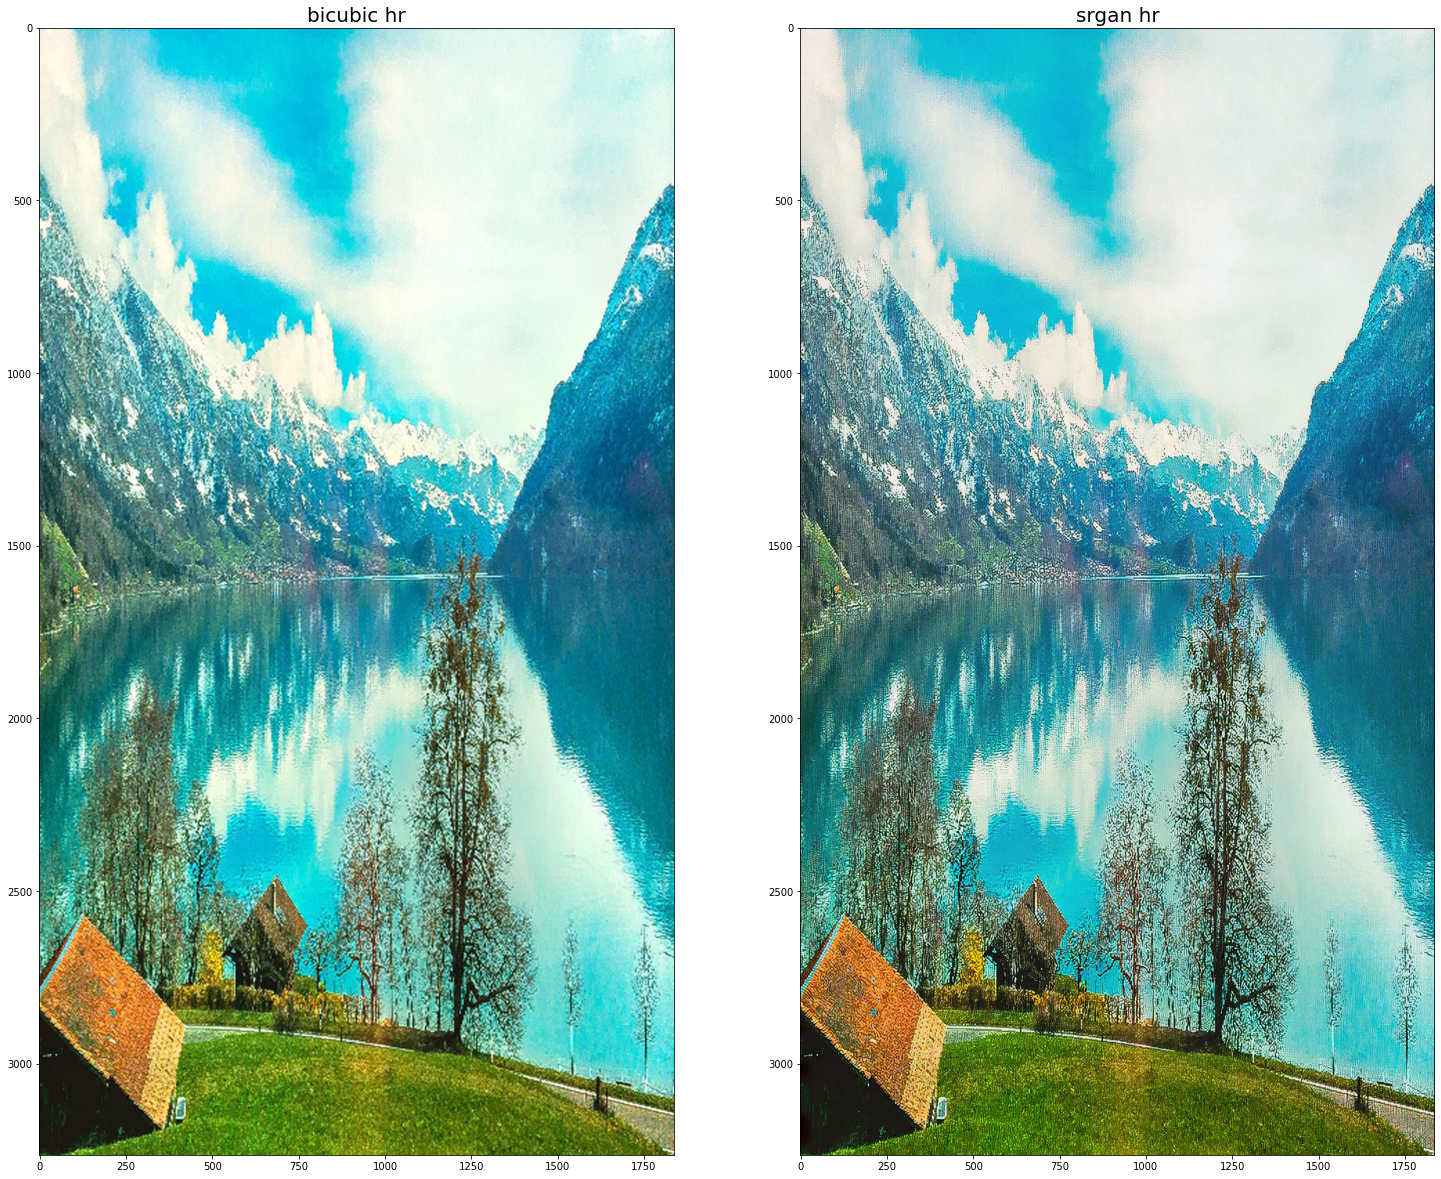

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,35))
plt.subplot(1,2,1)
plt.imshow(bicubic_hr)
plt.title('bicubic hr', fontsize=20)

# plt.figure(figsize=(100,100))
plt.subplot(1,2,2)
plt.imshow(srgan_hr)
plt.title('srgan hr', fontsize=20)




프로젝트 1-2.

(적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.
1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. cv2.resize()를 사용해 봅시다.
2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)


프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기
이전 Super Resolution의 활용 사례에 대해 살펴봤을 때, 단일 이미지가 아닌 영상에 대해 Super Resolution을 적용한 사례가 있었습니다. 이번에는 이미 학습된 SRGAN을 이용해 저해상도 영상을 고해상도 영상으로 바꿔보는 프로젝트를 수행해 봅시다.

실제로 동영상의 Super Resolution은 시간 순서에 따른 다수의 프레임 정보를 고려하는 것이 더 좋지만, 처음부터 학습시키기에 많은 시간이 소요됩니다. 여기서는 이전에 사용했던 SRGAN을 이용해 한 프레임씩 고해상도 이미지로 변환 시켜 모든 프레임에 대해 적용하고, 그 프레임들을 합쳐 동영상으로 만들어 봅시다.

각 프레임들을 모아 gif 파일을 만드는데 아래 라이브러리의 설치가 필요합니다.


In [24]:
!pip install imageio


1. gif 파일 불러오기
아래 주소에 몇 개의 gif 파일이 있습니다. 이 중 하나를 골라 다운 로드하여 아래 과정을 수행합시다. (한 개 이상의 gif 파일에 대해 아래 과정을 수행해야 합니다!)

GIF files https://drive.google.com/drive/folders/1OLsa4btdwNUiVJcOJgZe_C6-lwEoNr4e

다운받은 gif 파일을 아래와 같은 과정을 통해 각 프레임(이미지)을 불러올 수 있습니다. frames이란 리스트 안에 각각의 프레임이 들어 있습니다.


In [25]:
import cv2

# 다운받은 파일의 경로를 설정해 주세요.
gif = cv2.VideoCapture("/content/drive/MyDrive/DL_Study/AIFFEL/SuperResolution/fire_lr.gif")

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 14
frame 크기 : (282, 300, 3)



2. 프레임별 Super Resolution 진행하기
Bicubic interpolation과 SRGAN을 이용해 각각의 가로, 세로 픽셀 수를 4배로 늘려봅시다. Super Resolution이 완료된 각각의 결과를 frames_sr이라는 리스트에 넣어주세요.


In [39]:
srgan_hr_frames = []
bicubic_hr_frames = []

for f in frames:
  bicubic_hr = cv2.resize(
        f,
        dsize=(frames[0].shape[1], frames[0].shape[0]),
        interpolation=cv2.INTER_CUBIC
    )
  srgan_hr = apply_srgan(f)

  bicubic_hr_frames.append(bicubic_hr)
  srgan_hr_frames.append(srgan_hr)




3. 프레임을 합쳐 gif 만들기
위에서 frame_sr을 만들었다면 아래 코드와 같이 gif 파일을 생성할 수 있습니다. Bicubic 및 SRGAN의 결과를 각각 저장하여 2개 파일을 만들어 주세요.


In [40]:
import imageio

imageio.mimsave("bicubic_sr.gif", bicubic_hr_frames)
imageio.mimsave("srgan_hr.gif", srgan_hr_frames)

imageio.mimsave("/content/drive/MyDrive/DL_Study/AIFFEL/SuperResolution/bicubic_sr.gif", bicubic_hr_frames)
imageio.mimsave("/content/drive/MyDrive/DL_Study/AIFFEL/SuperResolution/srgan_hr.gif", srgan_hr_frames)




4. Jupyter notebook에 gif 표시하기
아래와 같이 다운받은 저해상도 gif 파일과 고해상도 gif 파일을 각각 jupyter 내에 출력하여 최종 제출해 주시면 됩니다. jupyter 내에 출력이 어려운 경우, GitHub에 저해상도, 고해상도 gif파일을 업로드 후 링크를 첨부해주시기바랍니다. Super Resolution이 잘 적용되었는지 시각적으로 확인하기 위해 아래의 width 옵션을 적당히 크게 해주세요. 저해상도 및 고해상도 시각화의 width 값은 같도록 설정해주세요.


In [37]:
from IPython.display import Image as show_gif

show_gif("/content/drive/MyDrive/DL_Study/AIFFEL/SuperResolution/fire_lr.gif", width=800) # width 는 적당히 큰 값으로 설정해주세요
show_gif("bicubic_sr.gif", width=800) # 위에서 설정한 width와 같은 값으로 설정해주세요
show_gif("srgan_hr.gif", width=800) # 위에서 설정한 width와 같은 값으로 설정해주세요

ValueError: ignored

NameError: ignored